In [1]:
import torch
import torch.optim as optim
from datasets import load_dataset
from tools import *
from model import *
from train import *
from plot import *
from eval import *

# https://huggingface.co/datasets/yoshitomo-matsubara/srsd-feynman_easy
dataset = load_dataset('yoshitomo-matsubara/srsd-feynman_easy')

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [2]:
def run_experiment(n_equation, plot=False, save=True, dist=True):
    train_loader, test_loader, features_, labels_, features, labels = prepare_data_loaders(dataset, n_equation, batch_size=batch_size, equation_size=equation_size)
    hist_train_loss, hist_test_loss = train_model(formuler, train_loader, test_loader, optimizer, criterion, scheduler, num_epochs)
    if plot:
        plot_loss_curves(hist_train_loss, hist_test_loss, start=0)
        # Plotting for training data
        x_train, formula_train = formuler(features_.to(device))
        x_train = x_train.detach().cpu()
        print(criterion(x_train.squeeze(1), labels_))
        print(features_.shape)
        plot_grid(features_, x_train, labels_, "Train")

        # Plotting for testing data
        x_test, formula_test = formuler(features.to(device))
        x_test = x_test.detach().cpu()
        print(criterion(x_test.squeeze(1), labels))
        print(features.shape)
        plot_grid(features, x_test, labels, "Test")
        if dist:
            plot_gradient_distributions(formuler, features_, device)

    min_loss, min_for = generate_minimal_loss_formula(formuler, features, features_, labels, device, criterion, model, prob_size=prob_size)
    if plot:
        x = decode(min_for, features.to(device))
        print(criterion(x.squeeze(1).requires_grad_(), labels.to(device)).detach().cpu())
        x = x.detach().cpu()
        plot_grid(features, x, labels, "predicted formula")
    if save:
        torch.save(model, f'saved_models\model-formula-{n_equation}.pth')
    return min_loss, min_for


### Experiment
Choose the formulas you want to find by selecting them in the equations list

<!-- An empty line here -->
<!-- An empty line here -->

![problems](problem_table.png)


6
EPOCH[0] test loss: 41.125834, train loss: 54.665100, weighted_loss: 54.665100
EPOCH[1] test loss: 26.402498, train loss: 43.555744, weighted_loss: 43.555744
EPOCH[2] test loss: 20.681190, train loss: 32.404720, weighted_loss: 32.404720
EPOCH[3] test loss: 6.427002, train loss: 16.688036, weighted_loss: 16.688036
EPOCH[4] test loss: 6.706927, train loss: 14.038946, weighted_loss: 14.038946
EPOCH[5] test loss: 5.332805, train loss: 6.891287, weighted_loss: 6.891287
EPOCH[6] test loss: 4.177893, train loss: 10.681940, weighted_loss: 10.681940
EPOCH[7] test loss: 3.870167, train loss: 6.100679, weighted_loss: 6.100679
EPOCH[8] test loss: 4.487296, train loss: 4.405845, weighted_loss: 4.405845
EPOCH[9] test loss: 5.229803, train loss: 5.020072, weighted_loss: 5.020072
EPOCH[10] test loss: 3.655748, train loss: 5.260375, weighted_loss: 5.260375
EPOCH[11] test loss: 2.950816, train loss: 4.133906, weighted_loss: 4.133906
EPOCH[12] test loss: 2.436096, train loss: 4.364231, weighted_loss: 4

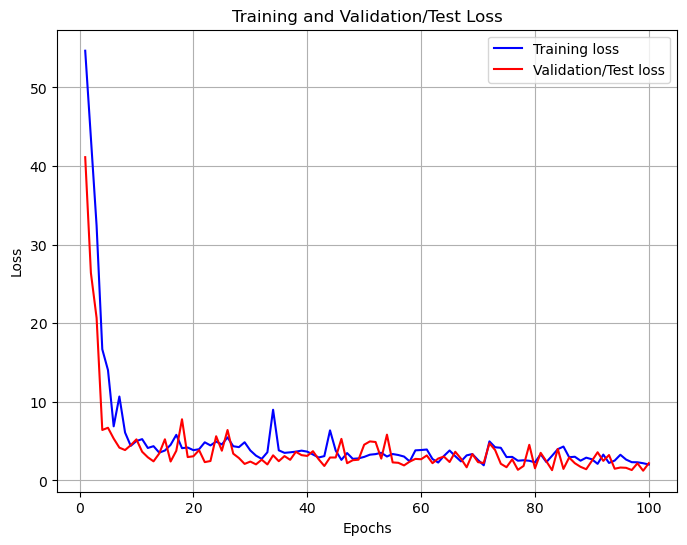

tensor(0.6815)
torch.Size([8000, 3])


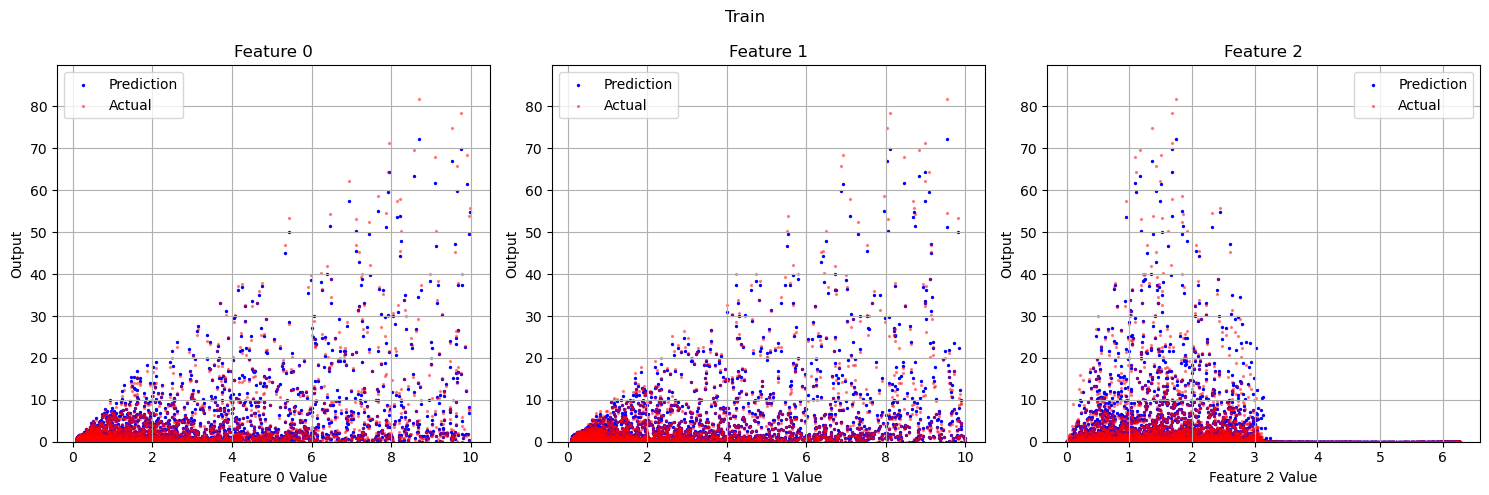

tensor(0.8084)
torch.Size([1000, 3])


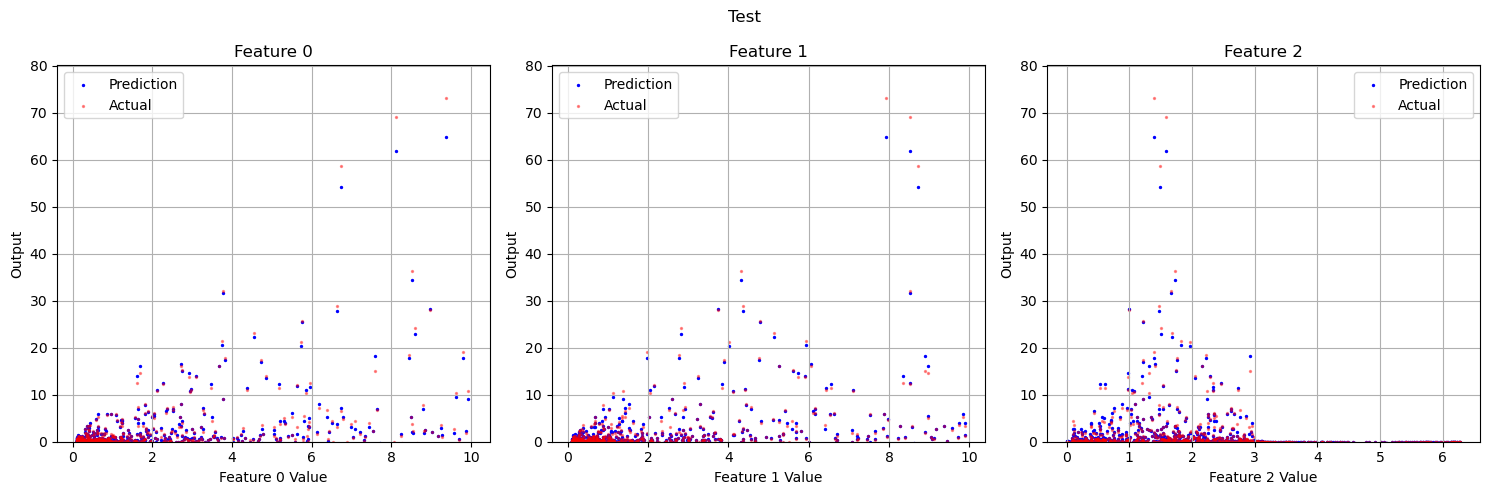

[[[['pi', 0], ['pi', 1], ['abs', 1], ['', 0]], [['pi', 1], ['square', 0], ['g', 0], ['square', 1]], [['g', 2], ['zeroise', 0], ['abs', 2], ['square', 2]]], [[[0, '*', 1], [2, '-', 0], [2, '*', 1], [1, '*', 2]], [[1], [2, '-', 0], [1, '-', 0], [1, '-', 2]], [[1], [0, '+', 1], [1, '-', 0], [1, '*', 2]]], [[['pi', 1], ['g', 1], ['g', 0], ['sqrt', 2]], [['g', 2], ['pi', 2], ['pi', 1], ['g', 0]]], [[[0], [1, '*', 0], [1, '+', 0], [0, '*', 1]]]]


Processing Vectors: 167vector [00:00, 835.41vector/s]

1081.1058349609375
[[['pi', 0], ['pi', 1], ['g', 2]], [[0, '*', 1], [1], [1]], [['pi', 1], ['g', 2]], [[0]]]


Processing Vectors: 9983vector [00:12, 907.16vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 20128vector [00:23, 933.67vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 30161vector [00:35, 928.88vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 40103vector [00:47, 821.96vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 50095vector [00:59, 875.74vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 60165vector [01:11, 861.85vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 70114vector [01:23, 871.11vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 80184vector [01:35, 911.66vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 90143vector [01:47, 888.58vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 100136vector [01:59, 845.86vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 110169vector [02:11, 862.25vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 120070vector [02:23, 891.55vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 130074vector [02:35, 822.94vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 140124vector [02:47, 852.89vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 150101vector [03:00, 775.44vector/s]

49.63683319091797
[[['pi', 0], ['pi', 1], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 160132vector [03:12, 880.11vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 170105vector [03:24, 757.34vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 180063vector [03:36, 763.15vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 190089vector [03:49, 896.79vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 200184vector [04:00, 889.19vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 210204vector [04:12, 898.58vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 220123vector [04:24, 849.23vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 230134vector [04:36, 870.82vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 240131vector [04:48, 771.84vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 250142vector [05:00, 869.97vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 260115vector [05:12, 850.09vector/s]

48.97336959838867
[[['abs', 1], ['square', 0], ['zeroise', 0]], [[0, '*', 1], [1], [1, '*', 2]], [['g', 0], ['pi', 2]], [[1, '*', 0]]]


Processing Vectors: 262144vector [05:14, 832.68vector/s]


tensor(48.9734)


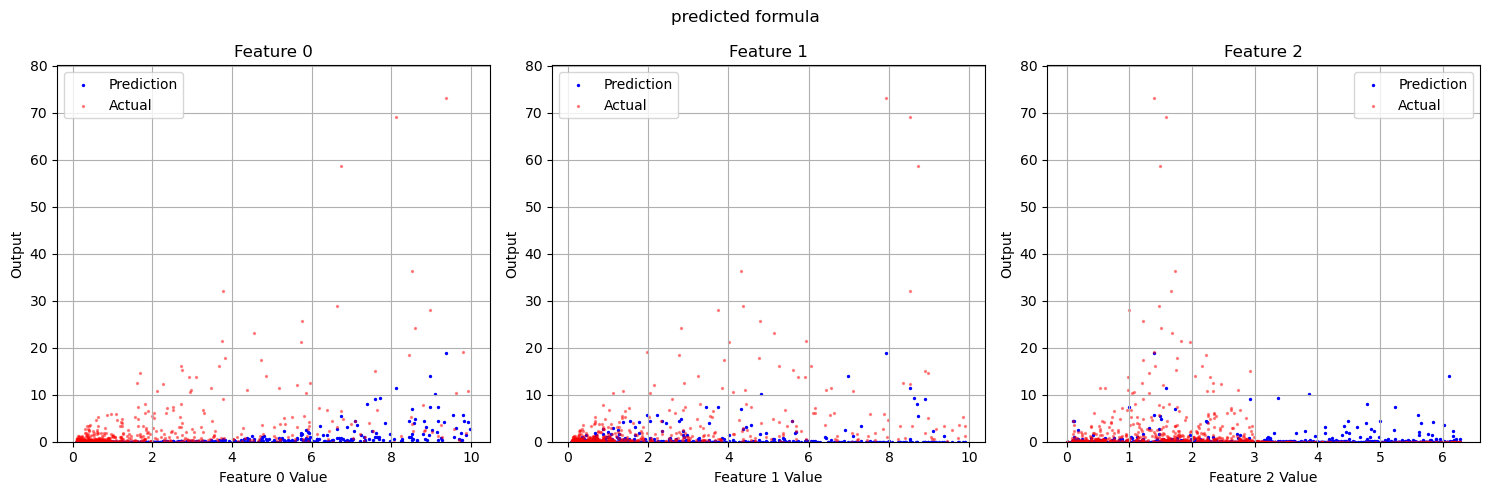

In [3]:
equation_size = 30
batch_size = 60
num_epochs = 100
prob_size = 4
losses = []
formulas = []
equations = [6]
for n_equation in equations:
    print(n_equation)
    x, y = data_prep(dataset, "test", n_equation, 30)
    input_size = x.shape[1]
    model = [input_size, input_size , 3, 2, 1]
    formuler = Formuler(model).to(device)
    optimizer = optim.Adam(formuler.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
    criterion =  torch.nn.MSELoss()
    min_loss, min_for = run_experiment(n_equation, plot=True, save=False, dist=False)
    losses.append(min_loss)
    formulas.append(min_for)

In [16]:
true_f = [[['', 1], ['', 0], ['sin', 2]],
   [[0, '*', 1], [2], [1, '*', 2]],
   [['', 0], ['', 1]],
   [[1, '*', 0]]]
train_loader, test_loader, features_, labels_, features, labels = prepare_data_loaders(dataset, n_equation, batch_size=batch_size, equation_size=equation_size)

In [17]:
out = decode(true_f, features.to(device))
criterion(out.squeeze(1), labels.to(device)).detach().cpu()

tensor(5.4294e-13)

In [4]:
losses, formulas

([48.97336959838867],
 [[[['abs', 1], ['square', 0], ['zeroise', 0]],
   [[0, '*', 1], [1], [1, '*', 2]],
   [['g', 0], ['pi', 2]],
   [[1, '*', 0]]]])